In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud

In [ ]:
!pip install netCDF4
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

In [ ]:
pip install giotto-tda

In [ ]:
!pip install git+https://github.com/manu-mannattil/nolitsa.git

# 1. Lectura de los datos

In [ ]:
#Scaffold code to load in data.  This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

In [ ]:
indices_ENSO=load_enso_indices()
indices_ENSO=indices_ENSO[0:1789]

In [ ]:
indices_ENSO.describe()

count    1789.000000
mean       -0.102594
std         0.771902
min        -2.490000
25%        -0.630000
50%        -0.160000
75%         0.330000
max         2.570000
dtype: float64

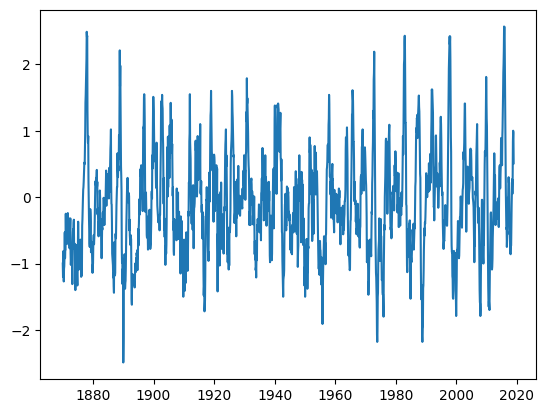

In [ ]:
plt.plot(indices_ENSO, label='Ground Truth')
plt.show()

# 2. Determinacion de los parametros optimos para un encaje

In [ ]:
max_periodic_dimension=30
max_periodic_time_delay=30
stride=1
tau,d= takens_embedding_optimal_parameters(indices_ENSO, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  16 
Optimal dimension:  8


Con Giotto se obtuvo que el optimo para el retraso es de 16 y la dimension optima es 8.

Verificando con nolitsa:

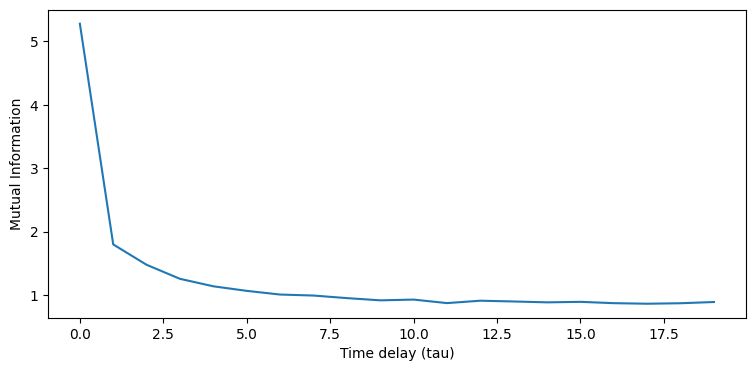

In [ ]:
from nolitsa import dimension, delay

plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(indices_ENSO, maxtau=20))

In [ ]:
def find_optimal_delay(x, maxtau=20):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

find_optimal_delay(indices_ENSO, maxtau=20)

9

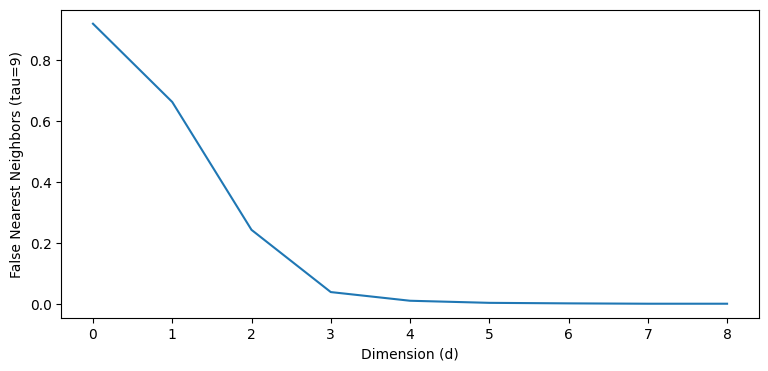

In [ ]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(indices_ENSO, tau=9, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=9)')
plt.plot(f1)

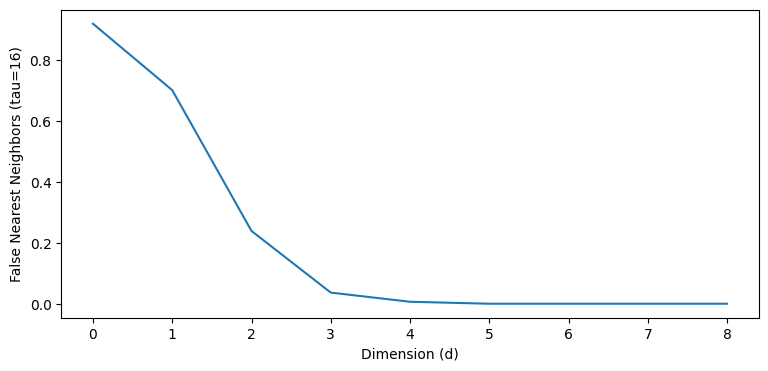

In [ ]:
dim = np.arange(1, 10)
f1, f2, f3 = dimension.fnn(indices_ENSO, tau=16, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=16)')
plt.plot(f1)

Se obtuvo que la dimension para el tiempo de retraso 9 y 16 puede tomarse como 3:

## Encaje con $τ = 9$ y $d = 3$

In [ ]:
encaje_T9 = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay = 9,
    dimension = 3,
    stride=1,
)

indices_ENSO_encaje_T9 = encaje_T9.fit_transform(indices_ENSO)

In [ ]:
indices_ENSO_encaje_T91 = indices_ENSO_encaje_T9[None, :, :]
# 0 - connected components, 1 - loops, 2 - voids
dimensiones = [0, 1, 2]

indices_T9_persistencia = VietorisRipsPersistence(
    homology_dimensions=dimensiones, n_jobs=1
)
indices_T9_persistencia.fit_transform_plot(indices_ENSO_encaje_T91)

array([[[0.        , 0.01      , 0.        ],
        [0.        , 0.01414214, 0.        ],
        [0.        , 0.01414214, 0.        ],
        ...,
        [0.20099752, 0.21771541, 2.        ],
        [0.19874607, 0.21023796, 2.        ],
        [0.16431677, 0.17349352, 2.        ]]])

In [ ]:
plot_point_cloud(indices_ENSO_encaje_T9)

## Encaje con $τ = 16$ y $d = 3$

In [ ]:
encaje_T16 = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay = 16,
    dimension = 3,
    stride=1,
)

indices_ENSO_encaje_T16 = encaje_T16.fit_transform(indices_ENSO)

In [ ]:
indices_ENSO_encaje_T161 = indices_ENSO_encaje_T16[None, :, :]
# 0 - connected components, 1 - loops, 2 - voids
dimensiones = [0, 1, 2]

indices_T16_persistencia = VietorisRipsPersistence(
    homology_dimensions=dimensiones, n_jobs=1
)
indices_T16_persistencia.fit_transform_plot(indices_ENSO_encaje_T161)

array([[[0.        , 0.01732051, 0.        ],
        [0.        , 0.01732051, 0.        ],
        [0.        , 0.01732051, 0.        ],
        ...,
        [0.19313207, 0.20856653, 2.        ],
        [0.18248288, 0.18466185, 2.        ],
        [0.16309506, 0.17320508, 2.        ]]])

In [ ]:
plot_point_cloud(indices_ENSO_encaje_T16)